# Kütüphanelerin Yüklenmesi

In [2]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt


from glob import glob
import random, os, datetime
import numpy as np
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization, Input,Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, AUC

# Google Drive Bağlantı

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Görüntü İşleme Aşamaları

In [ ]:
img1_paths="/content/drive/MyDrive/Colab Notebooks/nh"

In [ ]:
image_paths = [os.path.join(img1_paths, f) for f in os.listdir(img1_paths) if f.endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
img_list = []

for i in image_paths[0:20]:  # İlk 105 görüntü üzerinde işlem yapılır
    image = cv2.imread(i)  # Doğrudan dosya yolundan oku
    if image is None:
        print(f"{i} dosyası yüklenemedi.")
        continue
    image = cv2.resize(image,(224,224))
    # Renk uzayını RGB'ye çevir
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_list.append(image)

# Görüntülerin listesi başarıyla oluşturulduktan sonra
print(f"Toplam {len(img_list)} görüntü başarıyla yüklendi.")


Toplam 20 görüntü başarıyla yüklendi.


In [ ]:
img=img_list[19]

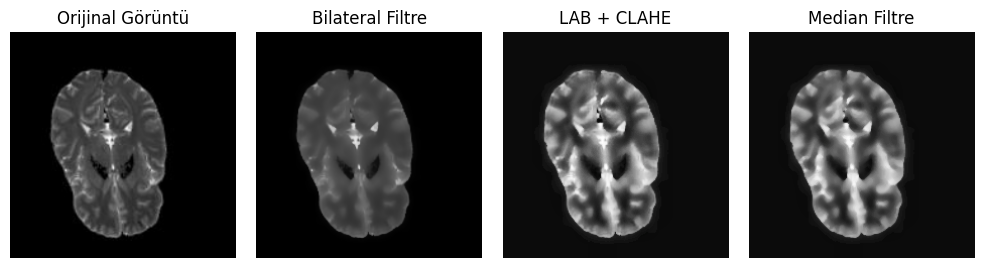

In [ ]:
# Bilateral Filtreleme
bilateral_filtered_image = cv2.bilateralFilter(img, d=10, sigmaColor=85, sigmaSpace=85)


# LAB Renk Uzayına Geçiş ve CLAHE Uygulaması
lab = cv2.cvtColor(bilateral_filtered_image, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
cl = clahe.apply(l)
limg = cv2.merge((cl, a, b))
sonhal = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# median

# Meadin Filtre
median_filtre=cv2.medianBlur(sonhal,3)


# Görüntüyü gösterme
plt.figure(figsize=(10, 10))

# Orijinal görüntü
plt.subplot(4, 4, 1)
plt.title("Orijinal Görüntü")
plt.imshow(img)
plt.axis("off")

#MedianFiltre
plt.subplot(4, 4, 4)
plt.title("Median Filtre")
plt.imshow(median_filtre)
plt.axis("off")


# Bilateral filtre sonucu
plt.subplot(4, 4, 2)
plt.title("Bilateral Filtre")
plt.imshow(bilateral_filtered_image)
plt.axis("off")


# CLAHE Uygulaması Sonucu
plt.subplot(4, 4, 3)
plt.title("LAB + CLAHE")
plt.imshow(sonhal)
plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
# Görüntü yollarını almak için fonksiyon
def get_image_paths(root_dir, num_images=None):
    all_images = []
    for extension in ["*.jpg", "*.jpeg", "*.png"]:
        all_images.extend(glob(os.path.join(root_dir, "**", extension), recursive=True))
    if num_images is None:
        return all_images
    else:
        return random.sample(all_images, min(num_images, len(all_images)))

# Görüntüleri göstermek için fonksiyon
def display_images(img_list):
    plt.figure(figsize=(15, 6))
    for i, img in enumerate(img_list[90:100]):  # İlk 10 görüntüyü gösterir
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.axis('off')
        plt.title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

# Bilateral filtre uygulama
def apply_bilateral_filter(img, d=10, sigmaColor=85, sigmaSpace=85):
    return cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)

# CLAHE uygulama
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # LAB renk uzayına dönüştür
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(8, 8))
    l = clahe.apply(l)  # CLAHE sadece L kanalına uygulanır
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)  # RGB'ye geri dönüştür

# Median filtre uygulama
def apply_median_filter(img, ksize=5):
    return cv2.medianBlur(img, ksize)

# Görüntülere işlemleri uygula
def process_images(img_list):
    processed_images = []  # İşlenmiş görüntülerin tutulacağı liste
    for img_path in img_list:
        # Görüntüyü yükle
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV'nin BGR formatını RGB'ye dönüştür

        # İşlemleri sırayla uygula
        img_bilateral = apply_bilateral_filter(img)  # Bilateral filtre
        img_clache = apply_clahe(img_bilateral)             # CLAHE
        imgson = apply_median_filter(img_clache)     # Median filtre

        # İşlenmiş görüntüyü listeye ekle
        processed_images.append(imgson)

    return processed_images


def save_images_with_structure(img_list, img_paths, root_dir, output_dir):
    for img_path, img in zip(img_paths, img_list):
        # Orijinal klasör yapısına göre göreli yolu al
        relative_path = os.path.relpath(img_path, start=root_dir)

        # Çıkış yolu oluştur
        output_path = os.path.join(output_dir, relative_path)

        # Çıkış klasörünü oluştur
        output_dirname = os.path.dirname(output_path)
        if not os.path.exists(output_dirname):
            os.makedirs(output_dirname)

        # Görüntüyü kaydet
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        print(f"Processed image saved at: {output_path}")

##  Grafik Görselleştirme
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

In [ ]:
# Görüntü yollarını alın
image_paths = get_image_paths(img_paths)

# İşlemleri uygulayın
processed_images = process_images(image_paths)

# İşlenmiş görüntülerin ilk 10'unu görselleştirin
display_images(processed_images)

save_images_with_structure(processed_images, image_paths, img_paths, output_paths)




# Veri Arttırma İşlemleri

In [5]:
## Veri arttırma yöntemi
train=ImageDataGenerator(
    horizontal_flip=True, ##yatay ve dikey eksende çevrilmesini sağlar
    vertical_flip=True,
    validation_split=0.3,  ## validation değerlerinin oranını verir. Genelde 0.20 yaparız.
    rescale=1./255,    ## standartlaşma işlemi yaparız.
    shear_range=0.1,   ## kesme dönüşümü uygular. yüzde 10 kadar uygular.
    zoom_range=0.1,   ## rastgele yüzde on büyütür

    width_shift_range=0.1,  #genişlik  yönünde kaydırır.
    height_shift_range=0.1, # yükseklik yönünde kaydırır.
)

val= ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

# Ana veri yolu ve artırılmış görüntülerin saklanacağı yol
output_paths = "/content/drive/MyDrive/Colab Notebooks/newimages"  # Orijinal görüntülerin yolu
minimum_target = 4000  # Her sınıf için hedeflenen maksimum görüntü sayısı
augmented_output = "/content/drive/MyDrive/Colab Notebooks/veriarttırma2"  # Artırılmış görüntülerin saklanacağı yol

# Veri artırma işlemi için ImageDataGenerator tanımı


# Artırılmış görüntülerin saklanacağı ana klasörü oluştur
if not os.path.exists(augmented_output):
    os.makedirs(augmented_output)

# Her sınıf için veri artırma işlemi
for class_dir in os.listdir(output_paths):
    class_path = os.path.join(output_paths, class_dir)

    # Klasör kontrolü
    if not os.path.isdir(class_path):
        continue

    # Yeni artırılmış görüntülerin kaydedileceği sınıf klasörü
    augmented_class_path = os.path.join(augmented_output, class_dir)
    if not os.path.exists(augmented_class_path):
        os.makedirs(augmented_class_path)  # Eksik klasörü oluştur

    # Mevcut görüntüleri ve sayısını kontrol et
    original_images = [f for f in os.listdir(class_path) if not f.startswith('.')]
    augmented_images = [f for f in os.listdir(augmented_class_path) if not f.startswith('.')]
    total_existing_images = len(original_images) + len(augmented_images)
    print(f"{class_dir} sınıfında toplam {total_existing_images} görüntü var (orijinal ).")

    # Sadece minimum hedefin altında olan sınıflar için artırma işlemi yapılır
    if total_existing_images < minimum_target:
        num_to_generate = minimum_target - total_existing_images
        print(f"{class_dir} sınıfı için {num_to_generate} yeni görüntü üretilecek.")

        generated_count = 0  # Üretilen görüntü sayısını takip et

        # Görüntüler üzerinde veri artırma işlemi
        for img_file in original_images:
            if generated_count >= num_to_generate:  # Hedeflenen görüntü sayısına ulaşıldıysa döngüyü durdur
                break

            img_path = os.path.join(class_path, img_file)
            img = load_img(img_path)  # Görüntüyü yükle
            x = img_to_array(img)  # Görüntüyü array'e çevir
            x = np.expand_dims(x, axis=0)  # 4D hale getir

            for batch in train.flow(
                x,
                batch_size=1,
                save_to_dir=augmented_class_path,
                save_prefix=os.path.splitext(img_file)[0],
                save_format='jpeg'
            ):
                generated_count += 1
                if generated_count >= num_to_generate:  # Hedeflenen görüntü sayısına ulaşıldıysa dur
                    break

        print(f"{class_dir} sınıfı için {generated_count} yeni görüntü üretildi.")
    else:
        print(f"{class_dir} sınıfı için yeterli görüntü var, veri artırma yapılmadı.")

print("Tüm veri artırma işlemleri tamamlandı!")


NORMAL sınıfında toplam 4990 görüntü var (orijinal ).
NORMAL sınıfı için yeterli görüntü var, veri artırma yapılmadı.
ST sınıfında toplam 756 görüntü var (orijinal ).
ST sınıfı için 3244 yeni görüntü üretilecek.
ST sınıfı için 3244 yeni görüntü üretildi.
PD sınıfında toplam 906 görüntü var (orijinal ).
PD sınıfı için 3094 yeni görüntü üretilecek.
PD sınıfı için 3094 yeni görüntü üretildi.
AD sınıfında toplam 3200 görüntü var (orijinal ).
AD sınıfı için 800 yeni görüntü üretilecek.
AD sınıfı için 800 yeni görüntü üretildi.
MS sınıfında toplam 650 görüntü var (orijinal ).
MS sınıfı için 3350 yeni görüntü üretilecek.
MS sınıfı için 3350 yeni görüntü üretildi.
Tüm veri artırma işlemleri tamamlandı!


In [6]:
aug_data="/content/drive/MyDrive/Colab Notebooks/aug_data"

# Modelin Hazırlanması

In [10]:

train_generator=train.flow_from_directory(aug_data, ## bu dizinde getirmesini isteriz.
                                          target_size=(224,224),
                                          batch_size=64,
                                          class_mode='categorical',  ## her bir sınıf için one hot encoding üretir. #sparche yazsaydık tek değer alır(0 1 2 3 4 5 gibi)
                                          subset='training')

validation_generator=val.flow_from_directory(aug_data,
                                        target_size=(224,224),
                                        batch_size=64,
                                        class_mode='categorical',
                                        subset='validation')

Found 13675 images belonging to 5 classes.
Found 5859 images belonging to 5 classes.


In [8]:
train_images, train_labels = next(train_generator)
print("First 5 labels from the training set:")
print(train_labels[:5])

First 5 labels from the training set:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


# Kendi CNN modelimiz

In [40]:
from tensorflow.keras.metrics import Precision, Recall, AUC
model_cnn= Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Conv2D(16,(3,3),activation="relu"),  #Evrişim katmanı-Özellik Çıkarır. ##32 tane 3,3 kernel ekle
    layers.Conv2D(16,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),  # Pooling katmanı - özellik haritasının boyutunu küçültür hesaplama maliyetini düşürür.
    Dropout(0.2),


    layers.Conv2D(32,(3,3),activation="relu"),  #Evrişim katmanı-Özellik Çıkarır. ##32 tane 3,3 kernel ekle
    # layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),  # Pooling katmanı - özellik haritasının boyutunu küçültür hesaplama maliyetini düşürür.
    Dropout(0.3),

    layers.Conv2D(64,(3,3),activation="relu"),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    Dropout(0.2),

    layers.Conv2D(128,(3,3),activation="relu"),
    # layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    Dropout(0.3),


    layers.Conv2D(256,(3,3),activation="relu"),
    # layers.Conv2D(256,(3,3),activation="relu"),
    Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512,activation="relu"), ##Tam bağımlı katman  --> özelliklerin ağırlıklarını öğrenir. 256 tane nöron vardır.
    BatchNormalization(),
    Dropout(0.3),
    layers.Dense(5,activation="softmax")
])




metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)


early_stopping_cnn = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                                   mode="min")

model_checkpoint_cnn= ModelCheckpoint(filepath='my_model_cnn.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)


In [ ]:
start_time = datetime.datetime.now()

history = model_cnn.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_cnn, model_checkpoint_cnn,lr_reduction])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100
 11/214 ━━━━━━━━━━━━━━━━━━━━ 2:32 751ms/step - accuracy: 0.3831 - auc: 0.7202 - loss: 1.7053 - precision: 0.4036 - recall: 0.2624

In [ ]:
plot_training_history(history, train_loss='loss', train_metric='auc', val_loss='val_loss', val_metric='val_auc')

In [25]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = model_cnn.evaluate(validation_generator, verbose=0)


In [26]:
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.7058905959129333
Validation Accuracy: 0.6943164467811584
Validation AUC: 0.682539701461792
Validation Precision: 0.9496652483940125
Validation Recall: 0.6958413124084473
Validation F1-Score: 0.8031767584918351


# EfficientNetB0


In [31]:

modelefficient=Sequential()

modelefficient.add(EfficientNetB0(weights='imagenet',include_top=False,input_shape=(224,224,3)))
modelefficient.add(layers.GlobalAveragePooling2D())
modelefficient.add(layers.Dropout(0.5))
modelefficient.add(layers.Dense(1024,activation="relu"))
modelefficient.add(layers.Dense(5,activation="softmax"))
modelefficient.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.00005),metrics=['accuracy'])
modelefficient.summary()

metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


modelefficient.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)


early_stopping = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint= ModelCheckpoint(filepath='my_model.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_eff = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,366,440 (20.47 MB)

 Trainable params: 5,324,417 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [32]:
start_time = datetime.datetime.now()

efficient = modelefficient.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, model_checkpoint,lr_reduction_eff])

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8042 - auc: 0.9626 - loss: 0.4271 - precision: 0.8306 - recall: 0.7864
Epoch 1: val_loss improved from inf to 2.37399, saving model to my_model.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.8044 - auc: 0.9626 - loss: 0.4267 - precision: 0.8307 - recall: 0.7866 - val_accuracy: 0.1799 - val_auc: 0.3611 - val_loss: 2.3740 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 796ms/step - accuracy: 0.8730 - auc: 0.9825 - loss: 0.2677 - precision: 0.8748 - recall: 0.8705
Epoch 2: val_loss did not improve from 2.37399
214/214 ━━━━━━━━━━━━━━━━━━━━ 205s 931ms/step - accuracy: 0.8731 - auc: 0.9825 - loss: 0.2677 - precision: 0.8748 - recall: 0.8706 - val_accuracy: 0.2017 - val_auc: 0.6907 - val_loss: 2.8080 - val_precision: 0.2137 - val_recall: 0.1896 - learning_rate: 0.0010
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.8946 

In [33]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = modelefficient.evaluate(validation_generator, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.5446559190750122
Validation Accuracy: 0.8480969667434692
Validation AUC: 0.8480969667434692
Validation Precision: 0.9726274609565735
Validation Recall: 0.8480969667434692
Validation F1-Score: 0.9061035122714004





# AlexNet


In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# AlexNet tarzında model oluşturma
modelalexnet = Sequential()
modelalexnet.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
modelalexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
modelalexnet.add(Flatten())
modelalexnet.add(Dense(4096, activation='relu'))
modelalexnet.add(Dropout(0.5))
modelalexnet.add(Dense(4096, activation='relu'))
modelalexnet.add(Dropout(0.5))
modelalexnet.add(Dense(5, activation='softmax'))

#metrics


metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]

# Modeli derleme
modelalexnet.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00005),
    metrics=metrics
)

# Model özeti
modelalexnet.summary()



early_stopping_alexnet = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint_alexnet= ModelCheckpoint(filepath='my_model_alexnet.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_alexnet = ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
start_time_alexnet = datetime.datetime.now()

alexnet = modelalexnet.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_alexnet, model_checkpoint_alexnet,lr_reduction_alexnet])

end_time_alexnet = datetime.datetime.now()
total_duration_alexnet = end_time_alexnet - start_time_alexnet
print("Trainin Time:", total_duration_alexnet)

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.5702 - auc: 0.8512 - loss: 1.0056 - precision: 0.6748 - recall: 0.3972
Epoch 1: val_loss improved from inf to 0.81242, saving model to my_model_alexnet.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.5708 - auc: 0.8515 - loss: 1.0043 - precision: 0.6753 - recall: 0.3982 - val_accuracy: 0.6161 - val_auc: 0.9352 - val_loss: 0.8124 - val_precision: 0.6203 - val_recall: 0.6117 - learning_rate: 5.0000e-05
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.8067 - auc: 0.9555 - loss: 0.4536 - precision: 0.8136 - recall: 0.7908
Epoch 2: val_loss improved from 0.81242 to 0.72987, saving model to my_model_alexnet.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 209s 942ms/step - accuracy: 0.8067 - auc: 0.9555 - loss: 0.4535 - precision: 0.8137 - recall: 0.7909 - val_accuracy: 0.6085 - val_auc: 0.9425 - val_loss: 0.7299 - val_precision: 0.6104 - val_recall: 0.6062 - learning_rate: 5.0000e-05
Epoch 3/100
214/214

In [38]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = modelalexnet.evaluate(validation_generator, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.3745681047439575
Validation Accuracy: 0.7695852518081665
Validation AUC: 0.7624167799949646
Validation Precision: 0.9726957082748413
Validation Recall: 0.7720359563827515
Validation F1-Score: 0.8608269989239195


# Resnet

In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

# ResNet50 tabanlı model oluşturma
modelresnet = Sequential()

metrics = [
    "accuracy",
    AUC(name='auc', multi_label=True),
    Precision(name='precision'),
    Recall(name='recall')
]


modelresnet.add(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
modelresnet.add(GlobalAveragePooling2D())
modelresnet.add(Dropout(0.5))
modelresnet.add(Dense(1024, activation="relu"))
modelresnet.add(Dense(5, activation="softmax"))

# Modeli derleme
modelresnet.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.0001,momentum=0.9,nesterov=True),
    metrics=metrics
)

# Model özeti
modelresnet.summary()



early_stopping_resnet = EarlyStopping(monitor='val_loss',
                           patience=20,
                           verbose=1,
                           restore_best_weights=True,
                               mode="min")

model_checkpoint_resnet= ModelCheckpoint(filepath='my_model_resnet.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)


lr_reduction_resnet= ReduceLROnPlateau(
    monitor='val_loss',    # İzlenecek metrik
    patience=3,            # Kaç epoch boyunca iyileşme olmadığında devreye girecek
    verbose=1,             # Detaylı çıktı için
    mode='min',           # Metrik 'min' veya 'max' modunda otomatik seçilecek
    factor=0.25,           # Öğrenme oranını bu faktörle çarpacak
    min_lr=0.000001        # Öğrenme oranının düşebileceği minimum değer
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,691,013 (98.00 MB)

 Trainable params: 25,637,893 (97.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
start_time_resnet = datetime.datetime.now()

resnet = modelresnet.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping_resnet, model_checkpoint_resnet,lr_reduction_resnet])

end_time_resnet = datetime.datetime.now()
total_duration_resnet = end_time_resnet - start_time_resnet
print("Trainin Time:", total_duration_resnet)

Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.5805 - auc: 0.8384 - loss: 1.0359 - precision: 0.7224 - recall: 0.3984
Epoch 1: val_loss improved from inf to 1.87590, saving model to my_model_resnet.keras
214/214 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.5812 - auc: 0.8389 - loss: 1.0343 - precision: 0.7228 - recall: 0.3993 - val_accuracy: 0.2502 - val_auc: 0.5682 - val_loss: 1.8759 - val_precision: 0.2157 - val_recall: 0.1987 - learning_rate: 1.0000e-04
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - accuracy: 0.8108 - auc: 0.9646 - loss: 0.4276 - precision: 0.8333 - recall: 0.7766
Epoch 2: val_loss did not improve from 1.87590
214/214 ━━━━━━━━━━━━━━━━━━━━ 217s 985ms/step - accuracy: 0.8108 - auc: 0.9646 - loss: 0.4275 - precision: 0.8333 - recall: 0.7767 - val_accuracy: 0.2919 - val_auc: 0.6563 - val_loss: 2.1838 - val_precision: 0.2767 - val_recall: 0.2492 - learning_rate: 1.0000e-04
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accurac

In [29]:
val_loss, val_accuracy, val_precision, val_recall, val_auc = modelresnet.evaluate(validation_generator, verbose=0)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation AUC: {val_auc}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-Score: {f1_score}")

Validation Loss: 0.4983433187007904
Validation Accuracy: 0.7322068810462952
Validation AUC: 0.7284519672393799
Validation Precision: 0.9634286165237427
Validation Recall: 0.7337115406990051
Validation F1-Score: 0.8330233558787558
